In [12]:
import pandas as pd
import seaborn as sns
dfNumbeo = pd.read_csv(r"data\Numbeo.csv",sep=";",decimal=",")
dfNumbeo.columns = ['Period', 'City', 'QualityOfLife', 'PurchasingPower', 'Safety', 'HealthCare', 'CostOfLiving', 'PropertyPriceToIncomeRatio', 'TrafficCommuteTime','Pollution', 'Climate']
dfNumbeo

,Period,City,QualityOfLife,PurchasingPower,Safety,HealthCare,CostOfLiving,PropertyPriceToIncomeRatio,TrafficCommuteTime,Pollution,Climate
0,2020,"Caracas, Venezuela",0.00,2.36,15.10,39.28,27.68,150.55,34.69,72.41,99.93
1,2020,"Auckland, New Zealand",165.38,83.93,54.54,73.43,76.06,12.09,37.96,29.19,99.89
2,2020,"Guatemala City, Guatemala",107.71,40.18,37.39,63.63,44.26,9.89,50.11,69.66,99.89
3,2020,"Nairobi, Kenya",73.29,24.85,39.92,56.46,42.08,26.17,56.94,80.42,99.79
4,2020,"Medellin, Colombia",117.13,29.90,48.66,77.28,30.19,17.90,38.29,64.89,99.76
...,...,...,...,...,...,...,...,...,...,...,...
2304,2012-Q1,"Cairo, Egypt",-35.66,18.35,61.33,70.83,52.69,15.51,58.75,129.50,NaN
2305,2012-Q1,"Tehran, Iran",-50.44,47.52,43.27,43.40,60.86,13.72,73.50,140.75,NaN
2306,2012-Q1,"Moscow, Russia",-54.72,46.75,47.33,37.75,86.77,28.06,61.50,116.61,NaN
2307,2012-Q1,"Kolkata, India",-74.08,49.55,27.97,19.72,32.96,15.13,74.25,145.50,NaN


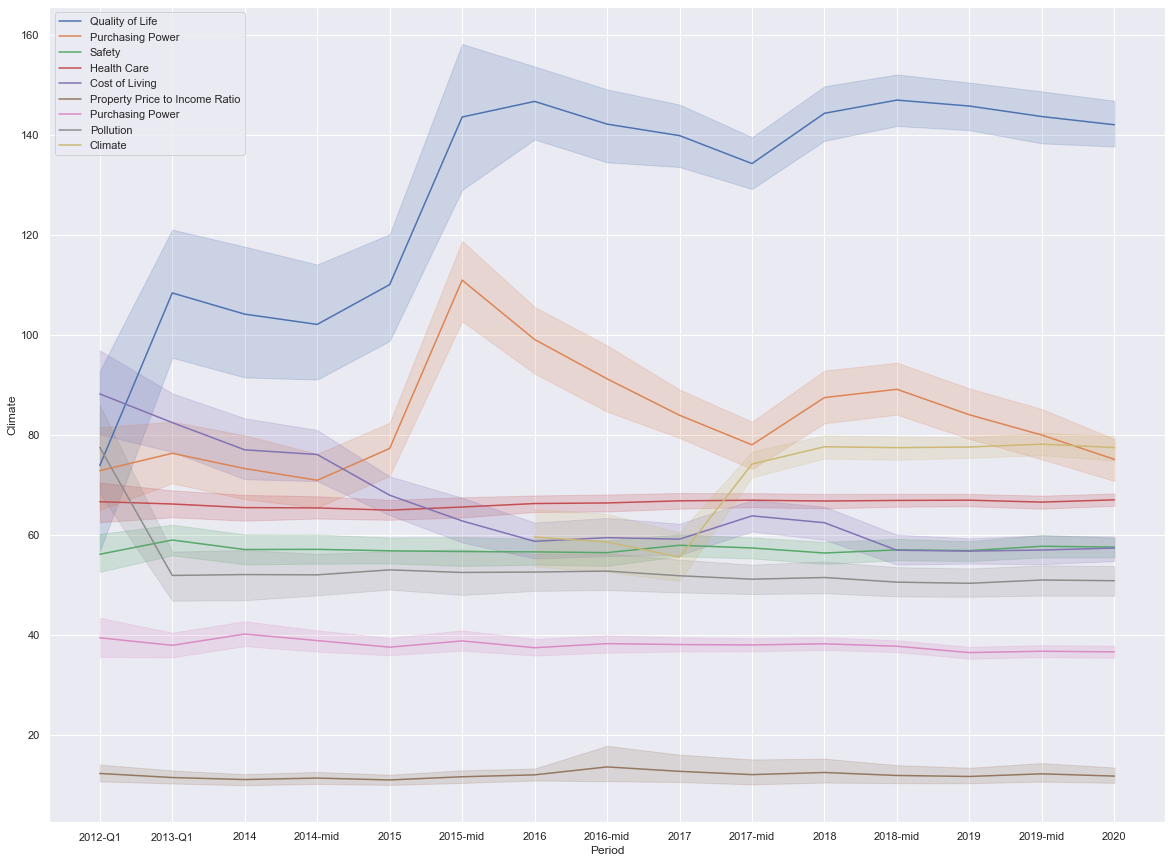

In [33]:
#visualizing quality of life rating aggregated over all countries in a period
sns.set(rc={'figure.figsize':(20,15)})
#idea plot all indices (quality of life, purchasingPower, Safety etc in a single linechart with multiple series)



g = sns.lineplot(x="Period", y="QualityOfLife", data=dfNumbeo,legend='brief',label='Quality of Life')
sns.lineplot(x="Period", y="PurchasingPower", data=dfNumbeo,legend='brief',label='Purchasing Power')
sns.lineplot(x="Period", y="Safety", data=dfNumbeo,legend='brief',label='Safety')
sns.lineplot(x="Period", y="HealthCare", data=dfNumbeo,legend='brief',label='Health Care')
sns.lineplot(x="Period", y="CostOfLiving", data=dfNumbeo,legend='brief',label='Cost of Living')
sns.lineplot(x="Period", y="PropertyPriceToIncomeRatio", data=dfNumbeo,legend='brief',label='Property Price to Income Ratio')
sns.lineplot(x="Period", y="TrafficCommuteTime", data=dfNumbeo,legend='brief',label='Purchasing Power')
sns.lineplot(x="Period", y="Pollution", data=dfNumbeo,legend='brief',label='Pollution')
sns.lineplot(x="Period", y="Climate", data=dfNumbeo,legend='brief',label='Climate')
g.ylabel='common ylabel'
g.figure.savefig('visuals/RankingsOverTime.png')


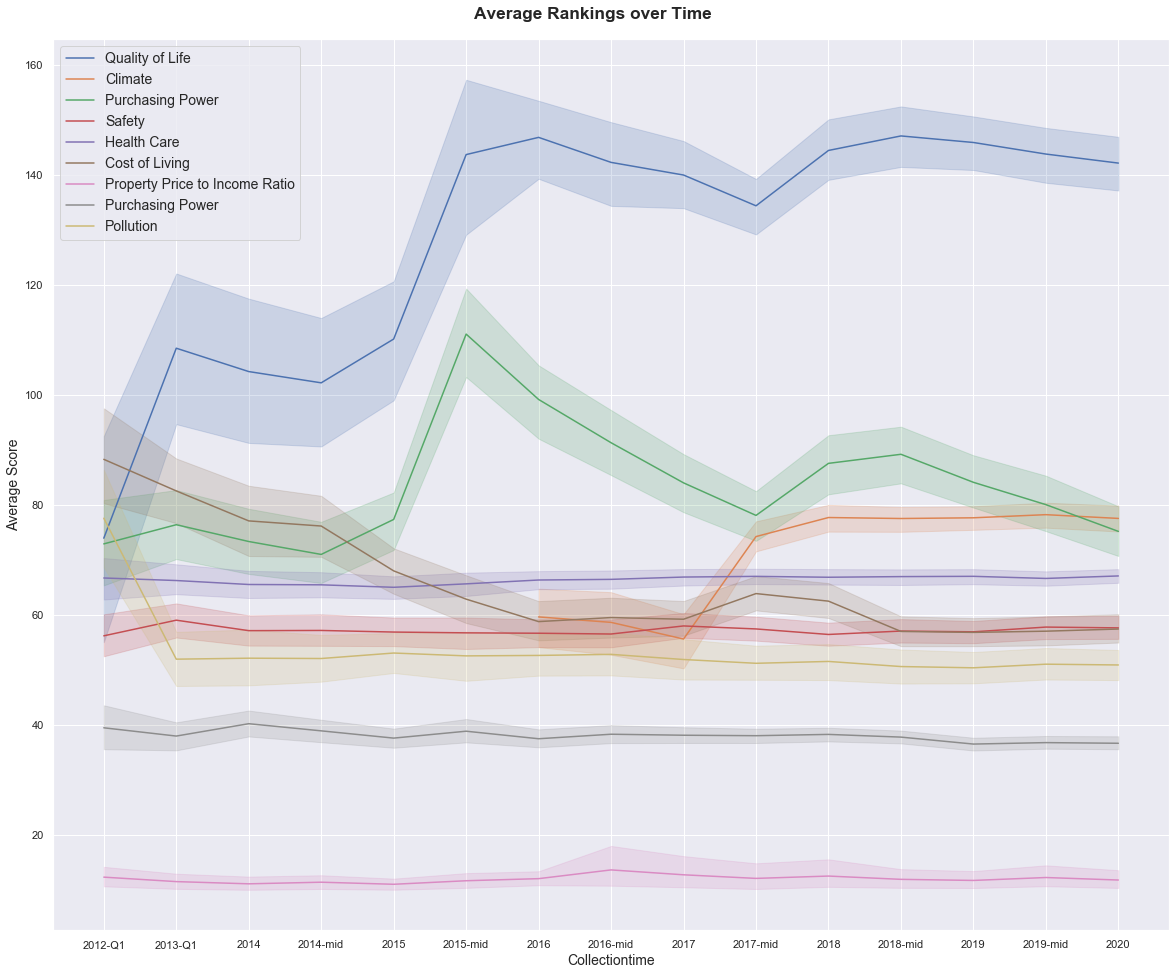

In [45]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.suptitle('Average Rankings over Time', fontsize='x-large', fontweight='bold')
#This is used for the main title. 'figure()' is a class that provides all the plotting elements of a diagram. 
#This must be used first or else the title will not show.fig.subplots_adjust(top=0.85) solves our overlapping title problem.
fig.subplots_adjust(top=0.95)


ax = fig.add_subplot(111)

fontdict={'fontsize': 14, 'fontweight' : 'book',    'verticalalignment': 'baseline',   'horizontalalignment': 'center'}

#ax.set_title('Plotting Tutorial', fontdict=fontdict)

sns.lineplot(x="Period", y="QualityOfLife", data=dfNumbeo,legend='brief',label='Quality of Life')
sns.lineplot(x="Period", y="Climate", data=dfNumbeo,legend='brief',label='Climate')
sns.lineplot(x="Period", y="PurchasingPower", data=dfNumbeo,legend='brief',label='Purchasing Power')
sns.lineplot(x="Period", y="Safety", data=dfNumbeo,legend='brief',label='Safety')
sns.lineplot(x="Period", y="HealthCare", data=dfNumbeo,legend='brief',label='Health Care')
sns.lineplot(x="Period", y="CostOfLiving", data=dfNumbeo,legend='brief',label='Cost of Living')
sns.lineplot(x="Period", y="PropertyPriceToIncomeRatio", data=dfNumbeo,legend='brief',label='Property Price to Income Ratio')
sns.lineplot(x="Period", y="TrafficCommuteTime", data=dfNumbeo,legend='brief',label='Purchasing Power')
sns.lineplot(x="Period", y="Pollution", data=dfNumbeo,legend='brief',label='Pollution')

plt.legend(fontsize=14)
#plt.title('Average Rankings over Time', fontdict=fontdict, color="black", position=(0.5,1));
plt.xlabel('Collectiontime', fontsize=14)
plt.ylabel('Average Score', fontsize=14);
fig.savefig('visuals/RankingsOverTime.png')